## Continuation of `einet` notebook 

Here we apply the main tools and functionality of netrd to various datasets.

Created by @liubov
Inspiration from coauthor of `einet` and `netrd` Brennan Klein.

## Effective information and network efficiency calculation 

The connectivity of a network conveys information about the dependencies between nodes. In https://arxiv.org/abs/1907.03902 authors showed that this information can be analyzed by measuring the uncertainty (and certainty) contained in paths along nodes and links in a network. 

Specifically, we apply here effective information and describe its behavior in "real" networks.

## 1. Loading data 

We first load matrices of various networks and then we generate networks from these networks. 

We also generate some specific directed and undirected networks in order to test EI measure on them (work in progress).
For each network we have the Transition-Probability Matrices (TPM) for which we will calculate the EI global measure.

*Note*: while generating networks we should check that the network have edge weights that sum to 1.0: 
    G = check_network(G)
    N = G.number_of_nodes()


In [8]:
import networkx as nx
import numpy as np

# 1. Generate a network
n=10
G = nx.star_graph(n)

n = 15 
k = 2
p = 0.5
G = nx.watts_strogatz_graph(n, k, p)



Star_dir      = np.array([[1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0]])



Star_undir      = np.array([[0.25, 0.25, 0.25, 0.25],
                      [1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0]])

Clique_undir = np.array([[0.25, 0.25, 0.25, 0.25],
                      [0.25, 0.25, 0.25, 0.25],
                      [0.25, 0.25, 0.25, 0.25],
                      [0.25, 0.25, 0.25, 0.25]])

#(fully connected network) 

Clique_dir = np.array([[0.5, 0.5, 0.0, 0.0],
                      [0.0, 1.0, 0.0, 0.0],
                      [0.25, 0.25, 0.25, 0.25],
                      [0.5, 0.5, 0.0, 0.0]])

#(fully connected network with directed links)


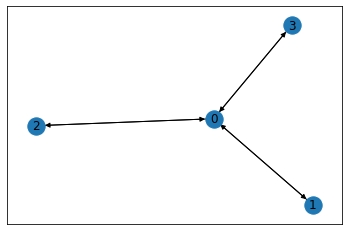

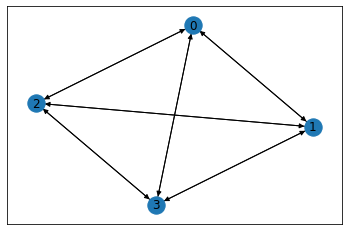

In [21]:
#plot networks
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

G_undir = nx.from_numpy_matrix(Star_undir)
G_undir = nx.DiGraph(G_undir)
nx.draw_networkx(G_undir, arrows=True)
plt.show()

G_cliq = nx.from_numpy_matrix(Clique_undir)
G_cliq = nx.DiGraph(G_cliq)
nx.draw_networkx(G_cliq, arrows=True)


plt.show()


Now we can compareeffective information for star directed vs.underected graphs for simple graph topologies.


In [11]:
from ei_net import *
import networkx as nx

print("effective_information of star directed network ", effective_information(Star_undir))

print("effective_information of star undirected network (links have both directions) ", effective_information(Star_dir))


# draw the networks and give explanation of networks

print("effective information of directed fully connected clique ", effective_information(Clique_dir))

print("effective information of fully connected clique (links have both directions) ", effective_information(Clique_undir))


effective_information of star directed network  0.4933927290103627
effective_information of star undirected network (links have both directions)  0.0
effective information of directed fully connected clique  0.49131465703639843
effective information of fully connected clique (links have both directions)  0.0


In [46]:
def threshold_matr(matrix, threshold):
    #function to threshold values of adjacency matrix
    #optimal thresholding does not work sometimes
    
    matrix[(matrix) < threshold] = 0.0
    
    return matrix



In [61]:
def thresh_matr_nonopt(matrix, threshold):
    #non-optimal function to threshold values of adjacency matrix with float 
    
    size = np.shape(matrix)
    
    matr_thresh = np.zeros((int(size[0]),int(size[0])))
    
    for i in range(int(size[0])):
        for k in range(int(size[0])):
            if np.float(matrix[i,k])>threshold:
                matr_thresh[i,k] = 1
    return matr_thresh

In [66]:
# loading data from matrix 

import pandas as pd
import csv
import numpy as np

# load data 
print('loading unthresholded climate network')
datContent = [i.strip().split() for i in open("C:/Users/lyubo/Documents/DATA_networks/climate_data/ClimateNetworks/correlation_matrix_anomalies_temp_1970_2010.dat").readlines()]

print('shape of climate network', np.shape(datContent))
matr = np.array(datContent)
print('nonzero', (np.count_nonzero(matr)))
print('nonzero', matr[1,2])


matr_thresh = thresh_matr_nonopt(matr, 0.0005) #threshold_matr
print('nonzero after threshold', (np.count_nonzero(matr_thresh)))

print('calculating climate network')
G_clim = nx.from_numpy_matrix(matr_thresh)

# write it as a new CSV file
#with open("./clim_net.csv", "wb") as f:
#    writer = csv.writer(f)
#    writer.writerows(datContent)
    
#df = pd.read_csv('./clim_net.csv')#('C:/Users/lyubo/Documents/DATA_networks/climate_data/ClimateNetworks/correlation_matrix_anomalies_temp_1970_2010.dat')



loading unthresholded climate network
shape of climate network (468, 468)
nonzero 219024
nonzero 9.571492537918885324e-01
nonzero after threshold 189742
calculating climate network


## 2. Estimation of effective information measure for a network


#### Definition.
From   two properties: 1. the uncertainty in the relationships among the nodes' out-weights (possible effects)  $\langle H(W^{out}_{i} )\rangle $, in-weights (possible causes) and 2.  how weight is distributed across the whole network, $H(\langle W^{out}_{i}\rangle)$, we can derive the amount of information in a network's causal structure, the *effective information* ($EI$), as:

$$ EI = H(\langle W^{out}_{i} \rangle) - \langle {H}(W^{out}_{i}) \rangle $$ 


#### The main idea
Networks with high $EI$ contain more certainty in the relationships between nodes in the network (since the links represent greater dependencies), whereas networks with low $EI$ contain less certainty.

#### The main questions 

1. How directionality of networks can influence $EI$ values for random networks?
2. How much thresholding real networks (for weighted ones) can reduce the $EI$ measure?

[1] Uncertainty and causal emergence in complex networks Brennan Klein and Erik Hoel, 2019. arXiv:1907.03902


In [24]:
from ei_net import *
import networkx as nx
G = nx.karate_club_graph()
print("effective_information(G) =", effective_information(G))

effective_information(G) = 2.3500950888734686


In [67]:
from ei_net import *
import networkx as nx

print("effective_information of climate network ", effective_information(G_clim))

effective_information of climate network  0.206522955805454


## Network effective information change vs. thresholding

Now we are testing effective information for differnt thrshold values.
Obvisously, when we threshold the matrix, the network becomes more "easy". But here is the question is WHEN it happens.

The main idea behind it is that usually it is quite challenging the choose the right threshold $\theta$ value.
Here the main idea is to calculate the moment when $EI$ of the network is dropping. This would be $\theta_{opt}$ optimal threshold. 



0.0
nonzero after threshold 190076
calculating climate network
0.02040816326530612
nonzero after threshold 174002
calculating climate network
0.04081632653061224
nonzero after threshold 152052
calculating climate network
0.061224489795918366
nonzero after threshold 127588
calculating climate network
0.08163265306122448
nonzero after threshold 105240
calculating climate network
0.1020408163265306
nonzero after threshold 88730
calculating climate network
0.12244897959183673
nonzero after threshold 76076
calculating climate network
0.14285714285714285
nonzero after threshold 66630
calculating climate network
0.16326530612244897
nonzero after threshold 59182
calculating climate network
0.18367346938775508
nonzero after threshold 52878
calculating climate network
0.2040816326530612
nonzero after threshold 47226
calculating climate network
0.22448979591836732
nonzero after threshold 42058
calculating climate network
0.24489795918367346
nonzero after threshold 37652
calculating climate networ

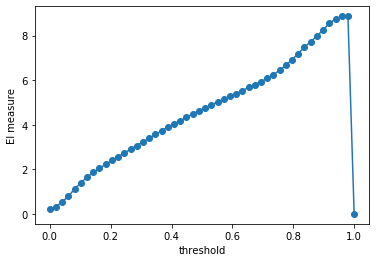

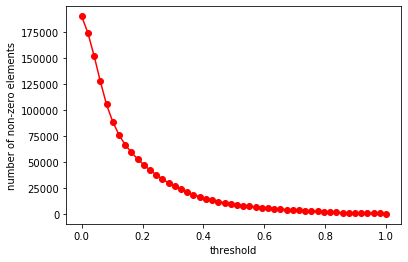

In [81]:
# now we are testing effective information for differnt thrshold values
import matplotlib.pyplot as plt

steps = 50 #number of steps for different thresholds applied to networks
EI_clim = np.zeros(steps)
N_nnz = np.zeros(steps)
ind = 0

for thresh_ind in np.linspace(0, 1, steps):
    #threshold a matrix with thresh_ind value  
    
    print(thresh_ind)
    #build a network from thresholding initial matrix "matr"
    
    matr_thresh = thresh_matr_nonopt(matr, thresh_ind) #threshold_matr
    print('nonzero after threshold', (np.count_nonzero(matr_thresh)))
    
    N_nnz[ind] = np.count_nonzero(matr_thresh)

    print('calculating climate network')
    G_clim = nx.from_numpy_matrix(matr_thresh)
    
    EI_clim[ind] = effective_information(G_clim)
    
    ind = ind +1

    
# plot number of nonzero values after each thresholding 
xarray = np.linspace(0, 1, steps)
plt.plot(xarray, EI_clim, 'o-')
plt.xlabel('threshold')
plt.ylabel('EI measure')

plt.show()

# plot EI of efficiency matrix 
plt.plot(xarray,N_nnz, 'ro-')
plt.xlabel('threshold')
plt.ylabel('number of non-zero elements')
plt.show()
    